<a href="https://colab.research.google.com/github/sathu0622/AI-Powered-System-for-Voice-Based-Resource-Type-Summarization-of-Historical-Content-for-VIS/blob/Resource_Type_Detection/Resource_Type_Detection_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2626 files belonging to 3 classes.
Using 2101 files for training.
Found 2626 files belonging to 3 classes.
Using 525 files for validation.
Class names: ['Books', 'Magazine', 'NewsPapers']
Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - accuracy: 0.6552 - loss: 0.8129 - val_accuracy: 0.7924 - val_loss: 0.4807
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8493 - loss: 0.3948 - val_accuracy: 0.8114 - val_loss: 0.4518
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8665 - loss: 0.3383 - val_accuracy: 0.7867 - val_loss: 0.4680
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8786 - loss: 0.2967 - val_accuracy: 0.7352 - val_loss: 0.6054
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9014 - loss: 0.2679 - val_accuracy: 0.7733 - val_loss: 0.5494
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/ste

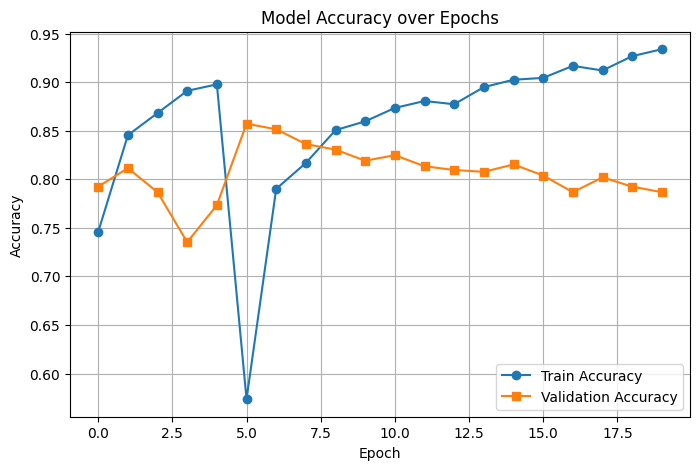

💾 Model saved to: /content/drive/MyDrive/Image/book_magazine_newspaper_model_finetuned.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

# -----------------------------
# Settings
# -----------------------------
dataset_dir = "/content/drive/MyDrive/Image_JPG"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20  # for fine-tuning

# -----------------------------
# Load datasets
# -----------------------------
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# -----------------------------
# Save class names BEFORE caching/prefetching
# -----------------------------
class_names = train_dataset.class_names
print("Class names:", class_names)

# -----------------------------
# Cache, shuffle, prefetch
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# -----------------------------
# Data Augmentation
# -----------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# -----------------------------
# Load MobileNetV2 base
# -----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# -----------------------------
# Build model with augmentation
# -----------------------------
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# -----------------------------
# Compile model
# -----------------------------
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Train with frozen base
# -----------------------------
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

# -----------------------------
# Fine-tune MobileNetV2
# -----------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1]+1
)

# -----------------------------
# Plot accuracy
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'],
         label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'],
         label='Validation Accuracy', marker='s')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Save model
# -----------------------------
model_path = "/content/drive/MyDrive/Image/book_magazine_newspaper_model_finetuned.keras"
model.save(model_path)
print(f"💾 Model saved to: {model_path}")


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

# -----------------------------
# Settings
# -----------------------------
IMG_SIZE = (224, 224)
class_names = ['Books', 'Magazine', 'NewsPapers']  # must match training class order
model_path = "/content/drive/MyDrive/Image/book_magazine_newspaper_model_finetuned.keras"

# -----------------------------
# Load model
# -----------------------------
model = load_model(model_path)

# -----------------------------
# Function to predict a single image
# -----------------------------
def predict_image(img_path):
    if not os.path.exists(img_path):
        print("❌ File not found:", img_path)
        return

    # Load and preprocess
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    print(f"Predicted Class: {pred_class} (Confidence: {confidence:.2f})")

# -----------------------------
# Test example
# -----------------------------
test_image_path = "/content/drive/MyDrive/Image/NewsPapers/000023.jpg"
predict_image(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: NewsPapers (Confidence: 0.54)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

# -----------------------------
# Settings
# -----------------------------
IMG_SIZE = (224, 224)
class_names = ['Books', 'Magazine', 'NewsPapers']  # same order as training
model_path = "/content/drive/MyDrive/Image/book_magazine_newspaper_model_finetuned.keras"

# Folder containing images to test
test_folder = "/content/drive/MyDrive/Image_JPG/Books"  # put images here

# -----------------------------
# Load model
# -----------------------------
model = load_model(model_path)

# -----------------------------
# Function to predict a single image
# -----------------------------
def predict_image(img_path):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array)
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)
        return pred_class, confidence
    except Exception as e:
        print(f"⚠️ Skipping {img_path}: {e}")
        return None, None

# -----------------------------
# Loop through all images in the folder
# -----------------------------
results = {}
for root, _, files in os.walk(test_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            pred_class, confidence = predict_image(img_path)
            if pred_class:
                print(f"{file} --> {pred_class} (Confidence: {confidence:.2f})")
                results[file] = (pred_class, confidence)

# -----------------------------
# Summary of predictions
# -----------------------------
summary = {cls: 0 for cls in class_names}
for _, (cls, _) in results.items():
    summary[cls] += 1

print("\n✅ Prediction Summary:")
for cls, count in summary.items():
    print(f"{cls}: {count} images")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
IMG-20251003-WA0005.jpg --> Books (Confidence: 0.71)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
IMG-20251003-WA0004.jpg --> Magazine (Confidence: 0.41)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
IMG-20251003-WA0010.jpg --> Books (Confidence: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
IMG-20251003-WA0011.jpg --> Books (Confidence: 0.76)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
IMG-20251003-WA0009.jpg --> Books (Confidence: 0.80)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
IMG-20251003-WA0008.jpg --> NewsPapers (Confidence: 0.51)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
IMG-20251003-WA0012.jpg --> NewsPapers (Confidence: 0.51)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
IMG-20251003-WA0015.jpg --> Books (Confidence: 0.99)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
IMG-20251003-WA0013.jpg --> Magazine (Confidence: 0.51)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
IMG-20251003-WA0016.jpg --> Books (Confidence: 0.76)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
IMG-20251003-WA0014.jpg --> Books (